In [51]:
!pip install patool

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 139.4 kB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [54]:
import patoolib
import os
patoolib.extract_archive("hacklytics data-20240211T030439Z-001.zip", outdir="./new_imgs")

patool: Extracting hacklytics data-20240211T030439Z-001.zip ...
patool: ... hacklytics data-20240211T030439Z-001.zip extracted to `./new_imgs'.


'./new_imgs'

In [1]:
from transformers import FlavaProcessor, FlavaImageProcessor, BertTokenizerFast, Blip2Processor

from transformers import CLIPTokenizerFast, CLIPModel, CLIPImageProcessor, BlipImageProcessor, AutoTokenizer, T5TokenizerFast
import pandas as pd
from torch.utils.data import Dataset
import os
from PIL import Image



tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained('facebook/opt-2.7b')
# tokenizer = T5TokenizerFast.from_pretrained('t5-base')
# tokenizer = Blip2Processor.from_pretrained('Salesforce/blip2-opt-2.7b')
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-image-captioning-large")


class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_processor, transforms):
        super(CustomDataset, self).__init__()
        self.dataframe = dataframe
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['Text']
        image_paths = [i for i in self.dataframe['Image']]
        images = []
        image_size = (224, 224)
        for image_path in image_paths:
            with open("/home/ueacd59b442911d1cdb9961bdfc2004f/Training/AI/GenAI/new_imgs/hacklytics_data/" + image_path, 'rb') as f:
                image = Image.open(f)
                image = image.resize(image_size)
                images.append(image)
        processed_images = self.image_processor(images=images, return_tensors='pt')
        processed_text = self.tokenizer(text=text, padding='max_length', return_tensors='pt', max_length=512, truncation=True)

        return processed_text, processed_images
        


In [2]:
# df = pd.read_csv("img_to_label.csv", header=0, index_col=False, quotechar='"')
df = pd.read_csv("Hacklytics GPT-4 Image to Text - Exterior.csv", header=0, index_col=False)

In [3]:
df

,Image,Text
0,useful1.jpeg,The image depicts the interior of a room that ...
1,useful2.jpeg,The image shows a multi-story building heavily...
2,useful4.jpeg,A multi-unit residential building is displaye...
3,useful5.jpeg,This is an image of a residential house engulf...
4,useful6.jpeg,The photo depicts an interior room severely da...
5,useful7.jpeg,A residential area is shown submerged in flood...
6,useful8.jpeg,"A large tree has fallen onto a house, piercing..."
7,useful9.jpeg,The photograph shows a close-up of a house's e...
8,useful10.jpeg,A house lies heavily damaged with a large tree...


In [4]:
[i for i in df['Image']]

['useful1.jpeg',
 'useful2.jpeg',
 'useful4.jpeg',
 'useful5.jpeg',
 'useful6.jpeg',
 'useful7.jpeg',
 'useful8.jpeg',
 'useful9.jpeg',
 'useful10.jpeg']

In [5]:
dataset = CustomDataset(df, tokenizer, image_processor, transforms=None)

In [6]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
from transformers import BlipModel, BlipForConditionalGeneration, Blip2ForConditionalGeneration

model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

In [8]:
import torch
print(torch.cuda.is_available())

False


In [9]:
import torch.nn as nn
import torch

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.cos = nn.CosineSimilarity(dim=-1)
        self.relu = nn.ReLU()
        
    def forward(self, text_embeddings, image_embeddings):
        batch_size = text_embeddings.shape[0]
        total_images = image_embeddings.shape[0]
        num_images_per_slice = total_images // batch_size
        image_embeddings_reshaped = image_embeddings.view(batch_size, num_images_per_slice, image_embeddings.shape[1])
        avg_summed = torch.einsum('ijk->ik', image_embeddings_reshaped)
        avg_image_embeddings = avg_summed / num_images_per_slice
        # Positive similarity
        positive_similarity = self.cos(text_embeddings, image_embeddings)
        # Assuming negative pairs are within the same batch; implement more complex negative sampling as needed
        negative_similarity = self.cos(text_embeddings, text_embeddings.roll(1, 0))
        # Calculate loss
        loss = self.relu(self.margin - positive_similarity + negative_similarity).mean()
        return loss

In [10]:
!pwd

/home/ueacd59b442911d1cdb9961bdfc2004f/Training/AI/GenAI


In [11]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)
contrastive_loss = ContrastiveLoss()
num_epochs = 10
from tqdm import tqdm


model.train()
for epochs in tqdm(range(num_epochs)):

    for batch in dataloader:
        optimizer.zero_grad()
        # print(batch[0]['attention_mask'].squeeze(0).shape)
        input_ids = batch[0]['input_ids'].squeeze(0)
        batch_size = input_ids.shape[0]
        attention_mask = batch[0]['attention_mask'].squeeze(0)
        total_images = batch[1]['pixel_values'].squeeze().shape[0]
        num_images_per_slice = total_images // batch_size
        image_embeddings_reshaped = batch[1]['pixel_values'].squeeze().view(batch_size, num_images_per_slice, batch[1]['pixel_values'].squeeze().shape[1], batch[1]['pixel_values'].squeeze().shape[2], batch[1]['pixel_values'].squeeze().shape[2])
        avg_summed = torch.einsum('bijkl->bjkl', image_embeddings_reshaped)
        avg_image_embeddings = avg_summed / num_images_per_slice
        # print(avg_image_embeddings.shape)
        # print(input_ids.shape)
        
        outputs = model(input_ids=input_ids,
                    pixel_values=avg_image_embeddings,
                    labels=input_ids, attention_mask=attention_mask)
        
        # text_embeddings = model.get_text_features(input_ids=batch[0]['input_ids'].squeeze(0), attention_mask=batch[0]['attention_mask'].squeeze(0))
        # image_embeddings = model.get_image_features(batch[1]['pixel_values'].squeeze())
        
        # loss = contrastive_loss(text_embeddings, image_embeddings)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
    print(f"Loss = {loss.item()}, epoch = {epochs+1}")

/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 10%|█         | 1/10 [00:17<02:40, 17.87s/it]

Loss = 9.741799354553223, epoch = 1


 20%|██        | 2/10 [00:33<02:11, 16.39s/it]

Loss = 8.757047653198242, epoch = 2


 30%|███       | 3/10 [00:45<01:43, 14.74s/it]

Loss = 8.347299575805664, epoch = 3


 40%|████      | 4/10 [01:01<01:31, 15.19s/it]

Loss = 7.962169647216797, epoch = 4


 50%|█████     | 5/10 [01:12<01:07, 13.54s/it]

Loss = 7.359447956085205, epoch = 5


 60%|██████    | 6/10 [01:22<00:50, 12.51s/it]

Loss = 7.326524257659912, epoch = 6


 70%|███████   | 7/10 [01:34<00:36, 12.02s/it]

Loss = 6.988405704498291, epoch = 7


 80%|████████  | 8/10 [01:44<00:22, 11.48s/it]

Loss = 6.7310309410095215, epoch = 8


 90%|█████████ | 9/10 [01:54<00:11, 11.02s/it]

Loss = 6.624990463256836, epoch = 9


100%|██████████| 10/10 [02:05<00:00, 12.52s/it]

Loss = 6.307730674743652, epoch = 10


In [25]:
!pip install huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [26]:
from huggingface_hub import notebook_login

notebook_login()

In [27]:
model.push_to_hub("BlipFineTuneHacklytics2024")

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/KrishnaSriIpsitMantri/BlipFineTuneHacklytics2024/commit/b6351709bfefd4bfa8a9d579354fefb65f373bb0', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='b6351709bfefd4bfa8a9d579354fefb65f373bb0', pr_url=None, pr_revision=None, pr_num=None)

In [12]:
from transformers import BlipProcessor, Blip2Processor

file_name = "imgs/set3/dmg1.jpg"
with open("./" + file_name, "rb") as f:
    raw_image = Image.open(f).convert('RGB')

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
# inputs = processor(raw_image, return_tensors="pt")
inputs = processor(images=raw_image, return_tensors="pt")

In [28]:
processor.push_to_hub("BlipFineTuneHacklytics2024")

CommitInfo(commit_url='https://huggingface.co/KrishnaSriIpsitMantri/BlipFineTuneHacklytics2024/commit/7506ecd507fbcc2cd58ab23052cd04770b4ad61a', commit_message='Upload processor', commit_description='', oid='7506ecd507fbcc2cd58ab23052cd04770b4ad61a', pr_url=None, pr_revision=None, pr_num=None)

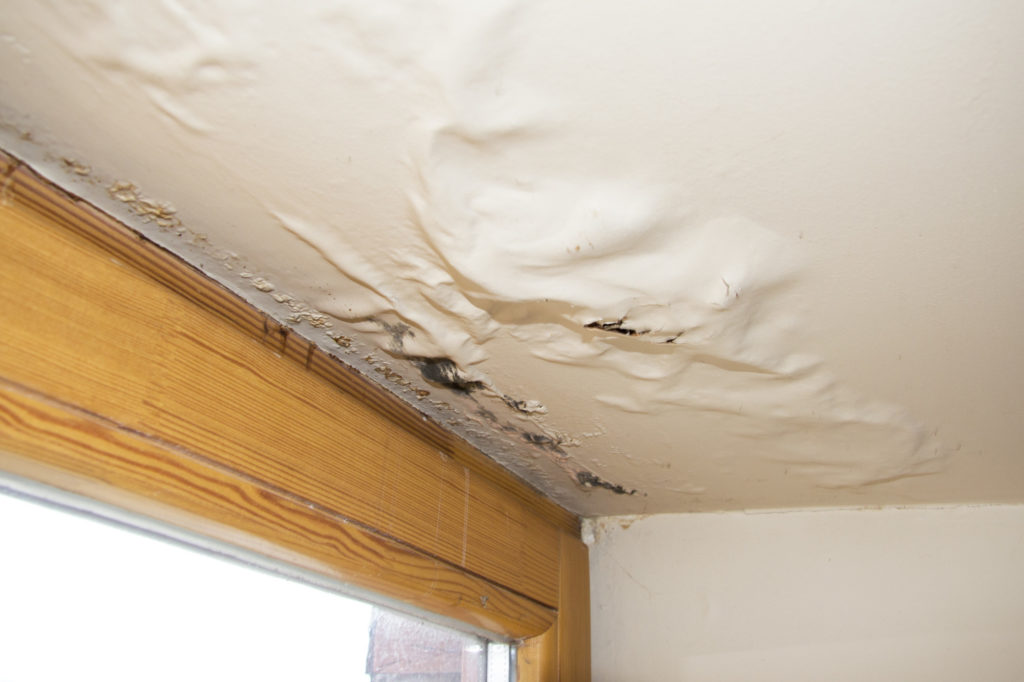

In [13]:
raw_image

In [14]:
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a close up of a ceiling with a lot of water damage on it
